# Basic Outlier Testing with Generated Data

### Get Data

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from test_connection import define_conn

In [78]:
engine, conn = define_conn()

data = pd.read_sql("""
    SELECT * FROM meas_values
""", conn).sort_values(by=["tool", "run_timestamp", "time"]).reset_index(drop=True)

data_summary = pd.read_sql("""
    SELECT * FROM meas_values_summary
""", conn).sort_values(by=["tool", "run_timestamp"]).reset_index(drop=True)

In [79]:
display(data.head(3))
print(data.shape)

,id,tool,run_timestamp,filename,time,value,outlier
0,19801,000,2024-01-22 07:10:35.715000+00:00,000_20240121_231035.715.csv,0,100.107971,False
1,19802,000,2024-01-22 07:10:35.715000+00:00,000_20240121_231035.715.csv,1,101.659725,False
2,19803,000,2024-01-22 07:10:35.715000+00:00,000_20240121_231035.715.csv,2,102.374084,False


(6300, 7)


In [80]:
display(data_summary.head(3))
print(data_summary.shape)

,tool,run_timestamp,mean_value,total_value,max_value,min_value
0,000,2024-01-22 07:10:35.715000+00:00,102.099502,3062.985062,103.686454,99.614622
1,000,2024-02-03 13:17:58.259000+00:00,99.163591,2974.907738,101.375072,96.836530
2,000,2024-02-03 13:18:44.342000+00:00,100.845600,3025.368000,102.632252,98.334298


(210, 6)


### EDA

In [81]:
data_summary.groupby("tool")[["mean_value", "total_value", "max_value", "min_value"]].agg("mean")

,mean_value,total_value,max_value,min_value
tool,,,,
000,99.883174,2996.495212,101.939794,97.729985
001,99.966442,2998.993251,102.163661,97.939957
002,100.327978,3009.839327,102.211971,98.312891
003,99.430416,2982.912468,101.537852,97.435196
004,99.604257,2988.127711,101.812944,97.441635
005,100.437209,3013.116280,102.315063,98.555117
006,100.032630,3000.978907,102.093260,97.953569
007,100.234578,3007.037327,102.142388,98.168749
008,100.340712,3010.221358,102.454774,98.245861


In [89]:
data["outlier"].sum() / len(data.index)

0.14809523809523809

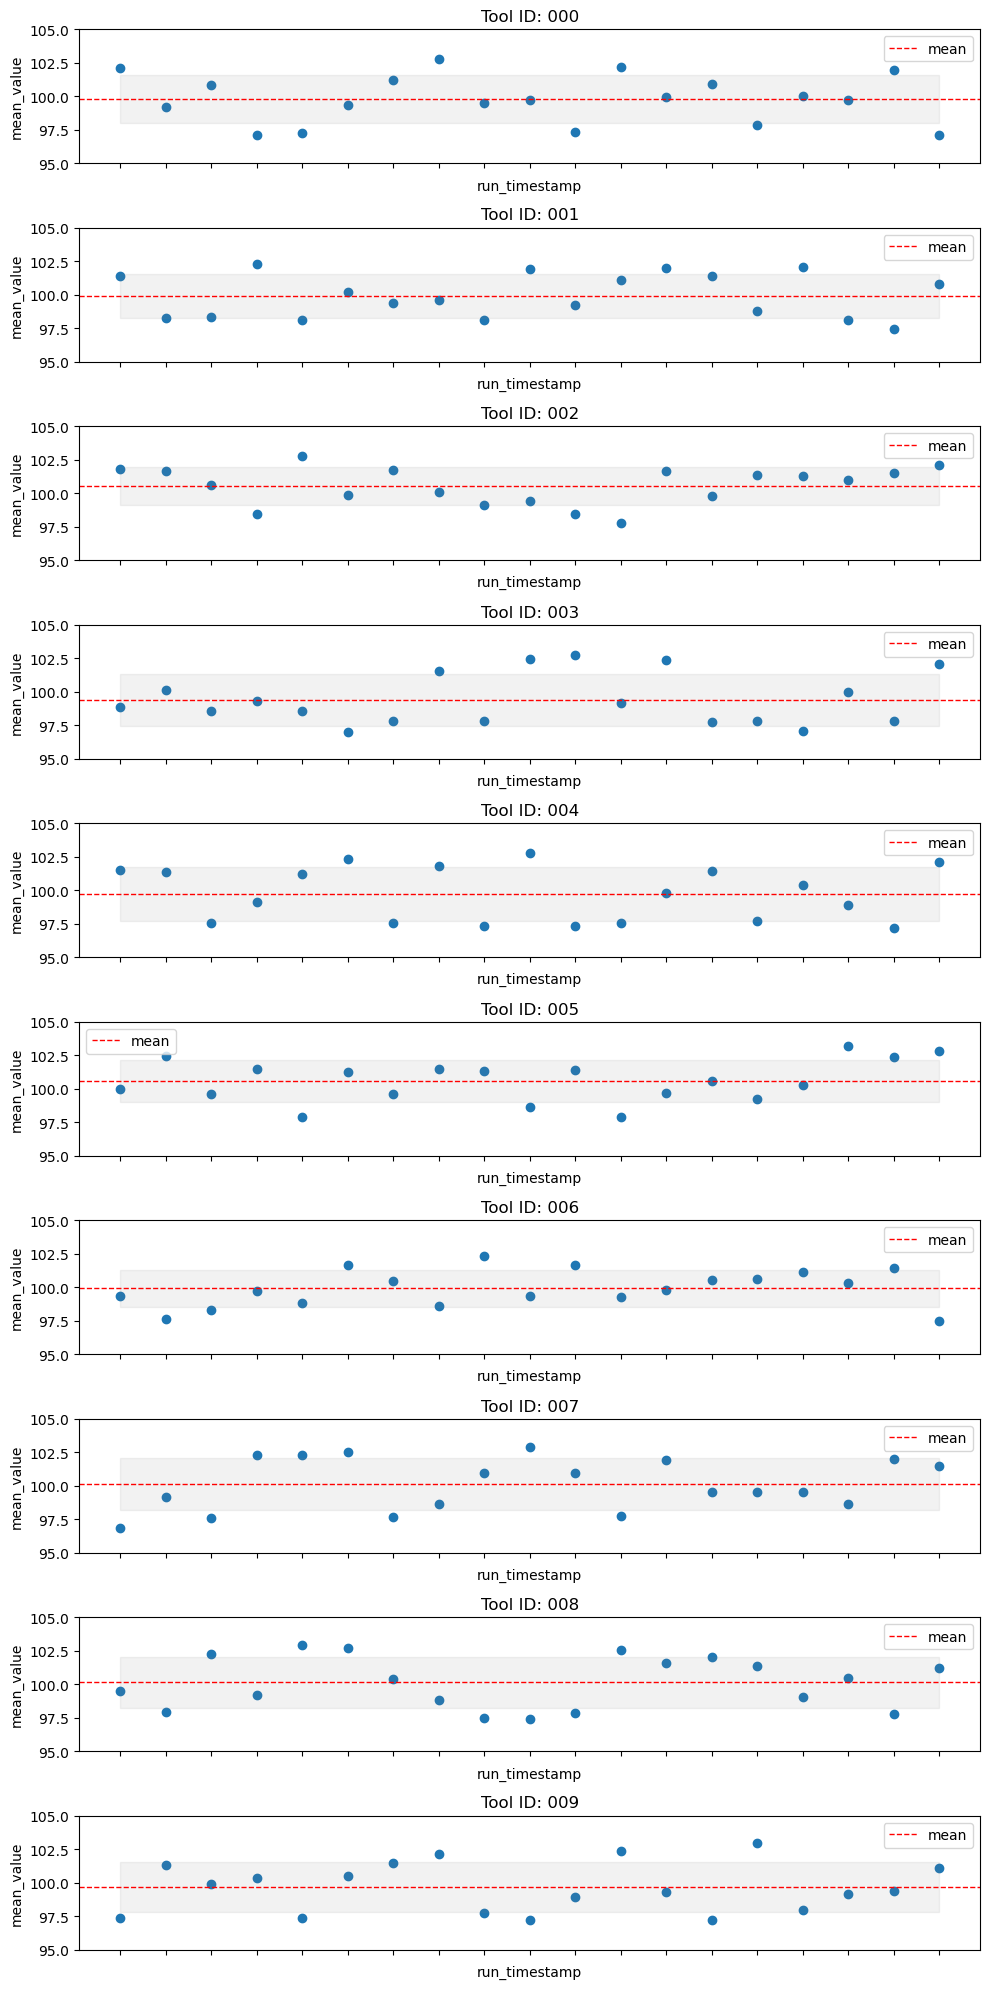

In [73]:
# Create the subplots
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))

# Iterate over each unique tool_id
for idx, tool in enumerate(data_summary['tool'].unique()):
    # Select data for the current tool_id
    tool_data = data_summary[data_summary['tool'].eq(tool)]
    mean = tool_data["mean_value"].mean()
    one_sd = tool_data["mean_value"].std()

    # Plot the data for the current tool
    axes[idx].scatter(x=tool_data['run_timestamp'].astype(str), y=tool_data['mean_value'])
    axes[idx].set_xlabel('run_timestamp')
    axes[idx].set_xticklabels([])
    axes[idx].set_ylabel('mean_value')
    axes[idx].set_title(f'Tool ID: {tool}')
    axes[idx].set_ylim(95, 105)
    # add std dev band
    axes[idx].axhline(mean, c="r", linestyle="--", label="mean", linewidth=1)
    axes[idx].fill_between(
        tool_data['run_timestamp'].astype(str), mean-one_sd, mean+one_sd, 
        color='gray',
        alpha=0.1
    )

    axes[idx].legend(loc="best")

plt.tight_layout()
plt.show()

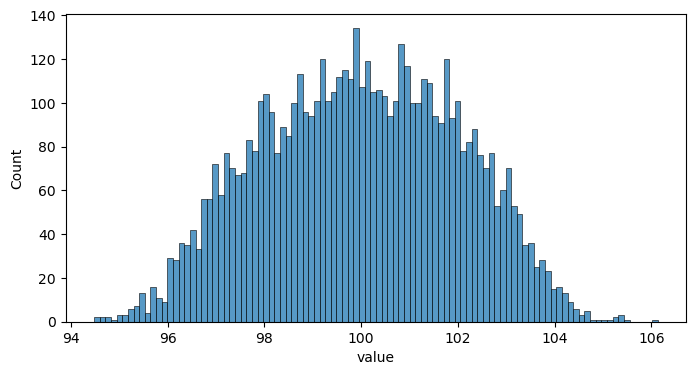

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.histplot(data["value"], bins=100)
plt.show()

## Test all raw data for outliers in meas_value

In [75]:
data["outlier"] = False
mask = (data["value"].gt(103) | data["value"].lt(97))
data.loc[mask, "outlier"] = True


In [76]:
data

,id,tool,run_timestamp,filename,time,value,outlier
0,19801,000,2024-01-22 07:10:35.715000+00:00,000_20240121_231035.715.csv,0,100.107971,False
1,19802,000,2024-01-22 07:10:35.715000+00:00,000_20240121_231035.715.csv,1,101.659725,False
2,19803,000,2024-01-22 07:10:35.715000+00:00,000_20240121_231035.715.csv,2,102.374084,False
3,19804,000,2024-01-22 07:10:35.715000+00:00,000_20240121_231035.715.csv,3,103.379155,True
4,19805,000,2024-01-22 07:10:35.715000+00:00,000_20240121_231035.715.csv,4,102.575684,False
...,...,...,...,...,...,...,...
5695,15686,009,2024-02-05 03:29:07.955000+00:00,009_20240204_192907.955.csv,25,101.482071,False
5696,15687,009,2024-02-05 03:29:07.955000+00:00,009_20240204_192907.955.csv,26,100.233866,False
5697,15688,009,2024-02-05 03:29:07.955000+00:00,009_20240204_192907.955.csv,27,101.080041,False
5698,15689,009,2024-02-05 03:29:07.955000+00:00,009_20240204_192907.955.csv,28,102.596462,False
